In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import copy

## Load Data

In [2]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ]),
    'val': transforms.Compose([transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

In [3]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(root = os.path.join(data_dir, x), transform = data_transforms[x])
                 for x in ['train', 'val']}

In [4]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: data/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: data/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [5]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 4)
              for x in ['train', 'val']}

In [6]:
imgs, labels = iter(dataloaders['train']).next()
imgs.shape

torch.Size([4, 3, 224, 224])

In [7]:
len(image_datasets['train'])

244

In [8]:
len(image_datasets['val'])

153

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 244, 'val': 153}


In [10]:
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [11]:
image_datasets['val'].classes

['ants', 'bees']

## Visualize images

In [12]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [13]:
imgs, labels = next(iter(dataloaders['train']))
imgs.shape

torch.Size([4, 3, 224, 224])

In [14]:
grid = torchvision.utils.make_grid(imgs)
grid.shape

torch.Size([3, 228, 906])

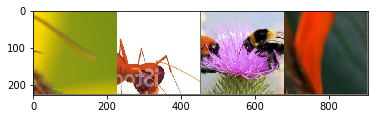

In [15]:
imshow(grid)

In [16]:
[class_names[x] for x in labels]

['bees', 'ants', 'bees', 'bees']

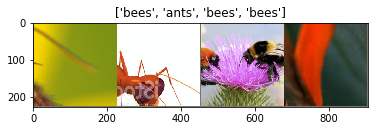

In [17]:
imshow(grid, [class_names[x] for x in labels])

## Train model

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.
            running_corrects = 0
            
            for batch in dataloaders[phase]:
                images, labels = batch
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                
                running_loss += loss.item() * images.size(0)
                running_corrects += (preds == labels).sum().item()
                
                '''
                print('outputs', outputs)
                print('-' * 5)
                print('preds', preds)                
                print('-' * 5)
                print('preds == labels', (preds == labels), (preds == labels).sum())
                print('-' * 5)
                print('running_corrects', running_corrects)
                print('-' * 5)
                break
                '''            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val_acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

## Visualize prediction

In [19]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for i in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[i]]))
                imshow(inputs[i])
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

## Finetuning convnet

In [20]:
model_ft = models.resnet18(pretrained = True)

In [21]:
model_ft.training

True

In [22]:
len(model_ft.state_dict().keys())

122

In [23]:
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

512


In [24]:
model_ft.fc.out_features

1000

In [25]:
model_ft.fc = nn.Linear(num_ftrs, 2)

In [26]:
model_ft.fc.in_features

512

In [27]:
model_ft.fc.out_features

2

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

In [29]:
# decay lr
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

## Train

In [30]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs = 25)

Epoch 1/25
----------
train loss: 0.5619, Acc: 0.7418
val loss: 0.4180, Acc: 0.8039

Epoch 2/25
----------
train loss: 0.6331, Acc: 0.7418
val loss: 0.2567, Acc: 0.8824

Epoch 3/25
----------
train loss: 0.5413, Acc: 0.7418
val loss: 0.2697, Acc: 0.8954

Epoch 4/25
----------
train loss: 0.6181, Acc: 0.7623
val loss: 0.2589, Acc: 0.8889

Epoch 5/25
----------
train loss: 0.4509, Acc: 0.8033
val loss: 0.2211, Acc: 0.9281

Epoch 6/25
----------
train loss: 0.3335, Acc: 0.8730
val loss: 0.2793, Acc: 0.9150

Epoch 7/25
----------
train loss: 0.5848, Acc: 0.7746
val loss: 0.6340, Acc: 0.7843

Epoch 8/25
----------
train loss: 0.4405, Acc: 0.8156
val loss: 0.3454, Acc: 0.8693

Epoch 9/25
----------
train loss: 0.3495, Acc: 0.8361
val loss: 0.2426, Acc: 0.9020

Epoch 10/25
----------
train loss: 0.2794, Acc: 0.8770
val loss: 0.2474, Acc: 0.8889

Epoch 11/25
----------
train loss: 0.3476, Acc: 0.8443
val loss: 0.2905, Acc: 0.8758

Epoch 12/25
----------
train loss: 0.2834, Acc: 0.8689
val loss

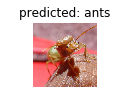

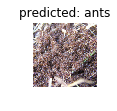

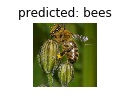

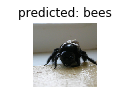

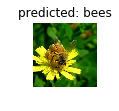

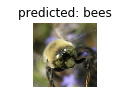

In [38]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [20]:
model_conv = models.resnet18(pretrained = True)

In [22]:
for param in model_conv.parameters():
    param.requires_grad = False

In [23]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [26]:
model_conv = train_model(model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs = 10)

Epoch 1/10
----------
train loss: 0.5854, Acc: 0.7131
val loss: 0.3042, Acc: 0.8431

Epoch 2/10
----------
train loss: 0.7604, Acc: 0.7254
val loss: 0.2475, Acc: 0.9020

Epoch 3/10
----------
train loss: 0.5044, Acc: 0.7869
val loss: 0.2055, Acc: 0.9412

Epoch 4/10
----------
train loss: 0.4636, Acc: 0.7787
val loss: 0.1703, Acc: 0.9542

Epoch 5/10
----------
train loss: 0.4149, Acc: 0.8320
val loss: 0.1990, Acc: 0.9346

Epoch 6/10
----------
train loss: 0.4214, Acc: 0.8525
val loss: 0.1669, Acc: 0.9542

Epoch 7/10
----------
train loss: 0.3788, Acc: 0.8238
val loss: 0.1821, Acc: 0.9477

Epoch 8/10
----------
train loss: 0.4081, Acc: 0.8279
val loss: 0.2031, Acc: 0.9346

Epoch 9/10
----------
train loss: 0.4203, Acc: 0.8238
val loss: 0.1949, Acc: 0.9346

Epoch 10/10
----------
train loss: 0.3040, Acc: 0.8648
val loss: 0.1889, Acc: 0.9412

Training complete in 6m 58s
Best val_acc: 0.9542


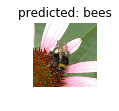

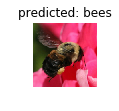

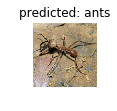

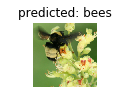

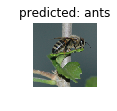

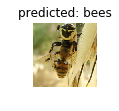

In [28]:
visualize_model(model_conv)